In [4]:
from datasets import load_dataset, Dataset, DatasetDict
from utils import *
from tqdm import tqdm
# from collect_activations import *
from transformers import AutoTokenizer,AutoModelForCausalLM
from collections import defaultdict
import os
from load_gemma import load_gemma_autoencoders
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['HF_HOME']="/mnt/data2/nirmal/scaling_feature_discovery/scaling_feature_discovery/huggingface"
from nnsight import LanguageModel
from scipy import stats
import numpy as np
import torch.nn.functional as F
from einops import einsum
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import pandas as pd
# from huggingface_hub import HfApi

In [5]:
device="cuda"

In [6]:
model_name = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True).to(device)  # Enable hidden states

# model = LanguageModel("google/gemma-2-2b-it", device_map=device,dispatch=True,torch_dtype="float16")

/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### tsne on template dataset

In [27]:
dataset=load_dataset("nirmalendu01/template_jailbreak",split="train")
template='''<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
'''

In [28]:
cache=defaultdict(list)
with tqdm(total=len(dataset), desc="Caching latents") as pbar:
    for i,item in enumerate(iter(dataset)):
        with torch.no_grad():
            inputs=tokenizer(template.format(prompt=item["test_case"]),return_tensors="pt",padding="max_length",max_length=512,truncation=True).to(device)
            outputs=model(**inputs)
            for i,item in enumerate(outputs.hidden_states[1:]):
                cache[f".model.layers.{i}"].append(item[0,-1,:].tolist())
        # Update the progress bar
        pbar.update(1)

Caching latents: 100%|██████████| 1218/1218 [03:31<00:00,  5.76it/s]


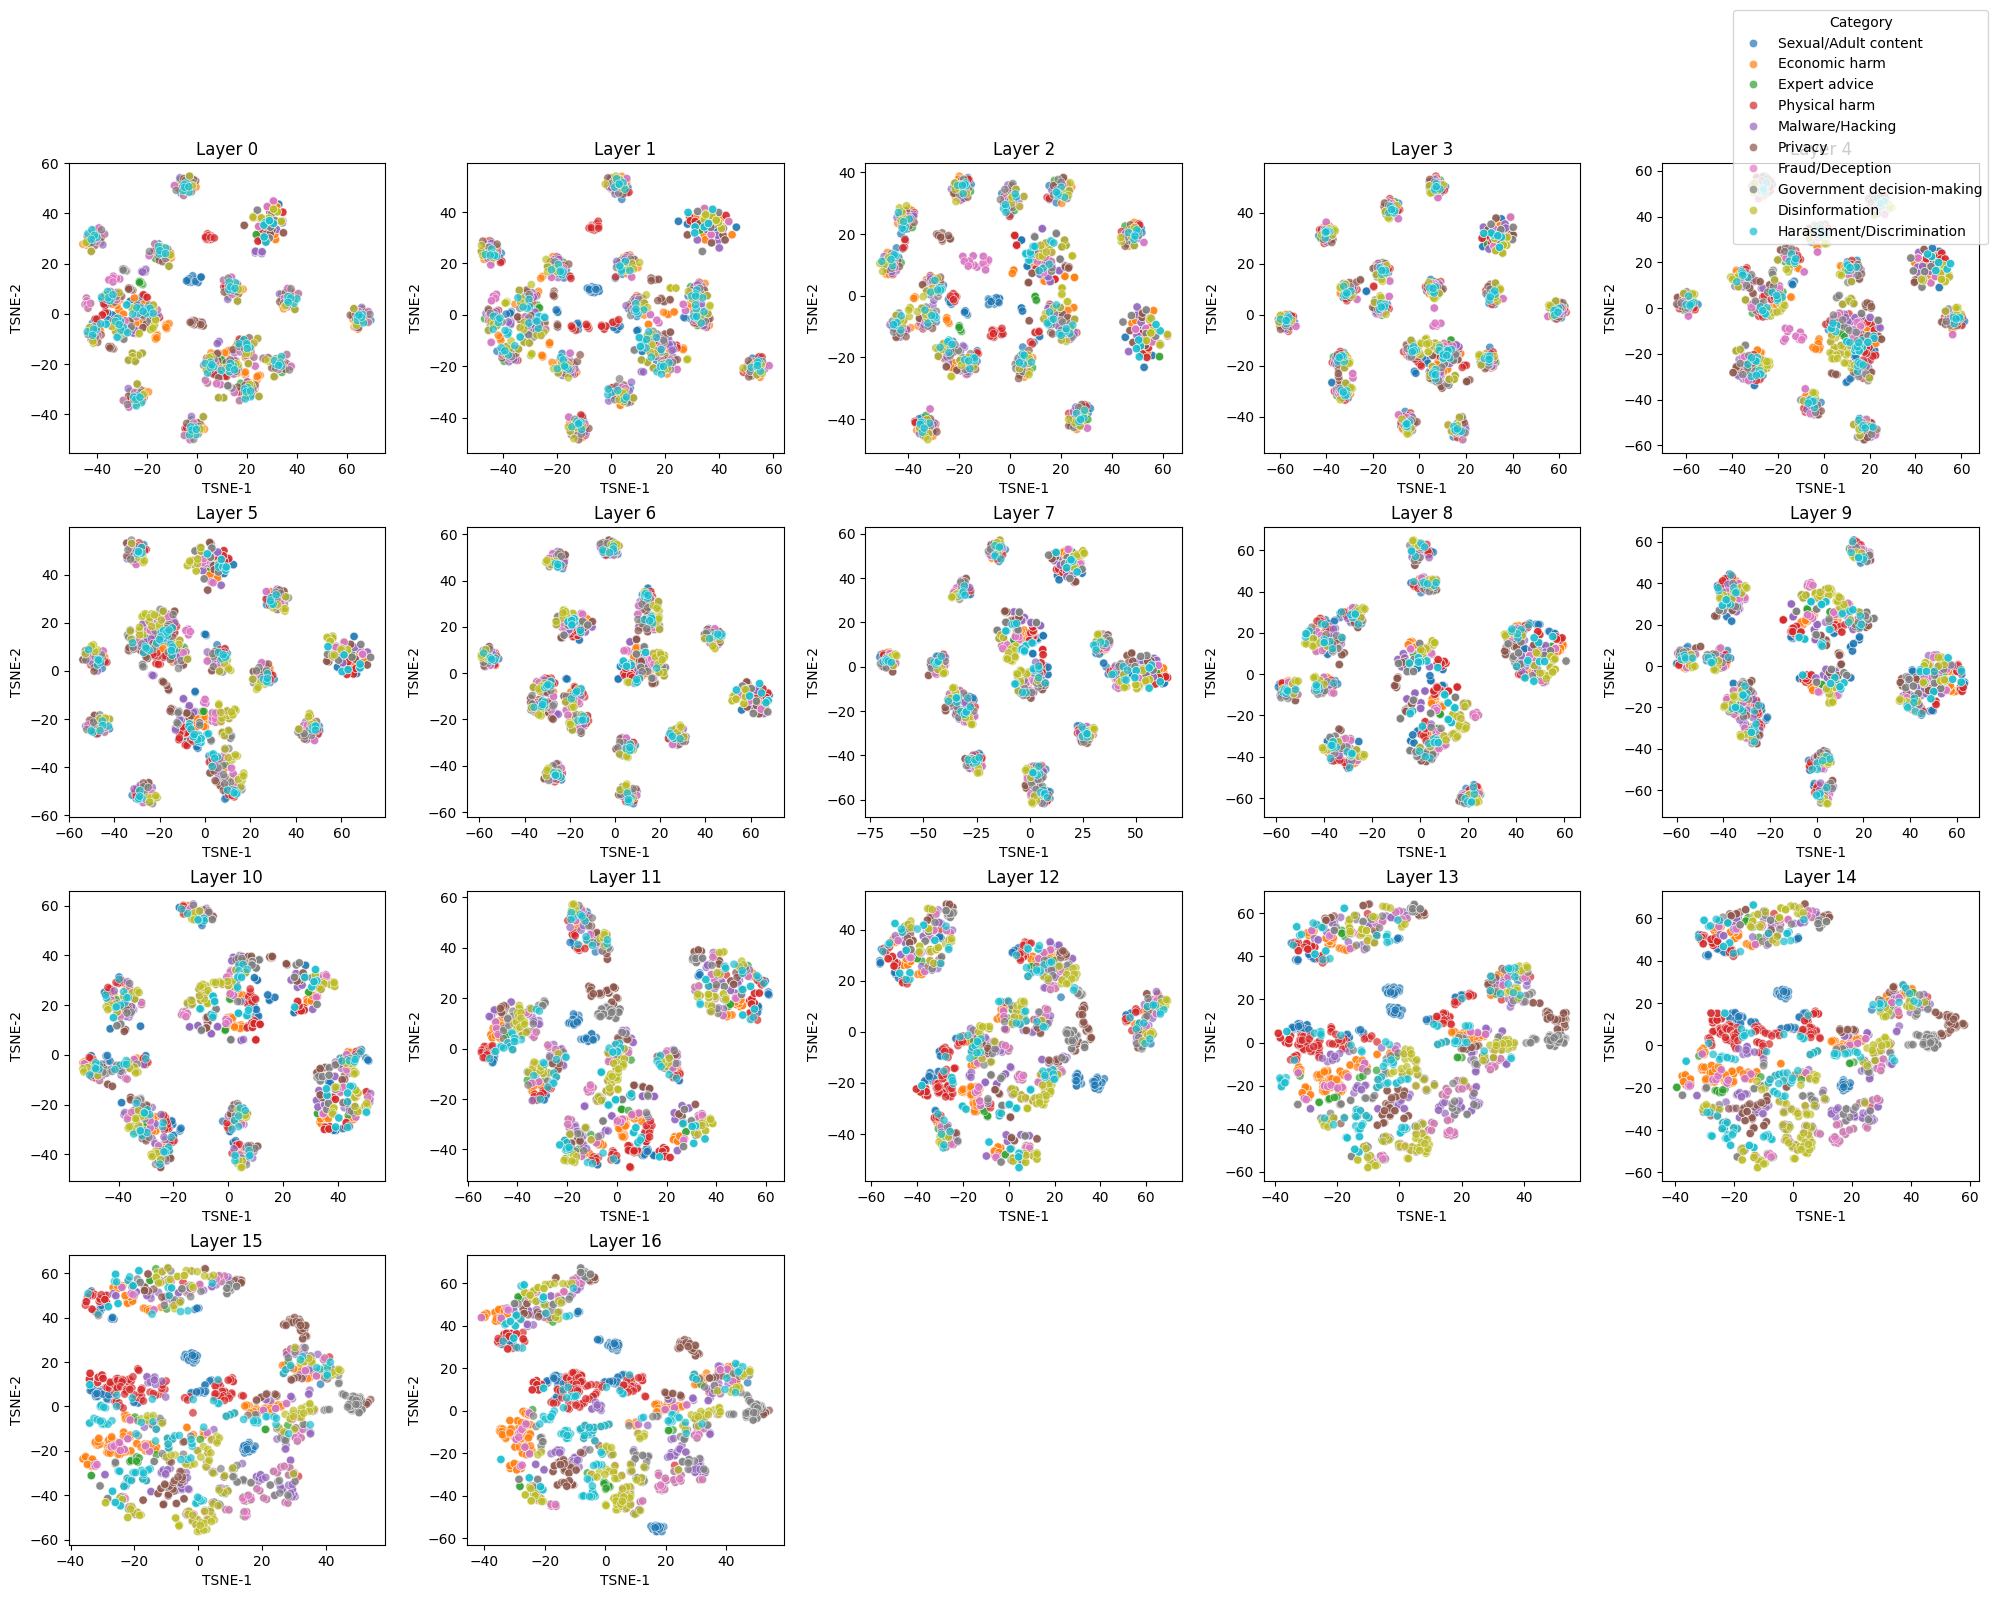

In [16]:
num_layers = 17  # Number of layers to visualize
cols = 5  # Max number of columns per row
rows = (num_layers + cols - 1) // cols  # Calculate required rows dynamically

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust size as needed
axes = axes.flatten()  # Flatten in case of multiple rows

# Loop through layers and plot in subplots
for layer in range(num_layers):
    X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="TSNE-1", y="TSNE-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove extra empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()

### contour plot on template dataset

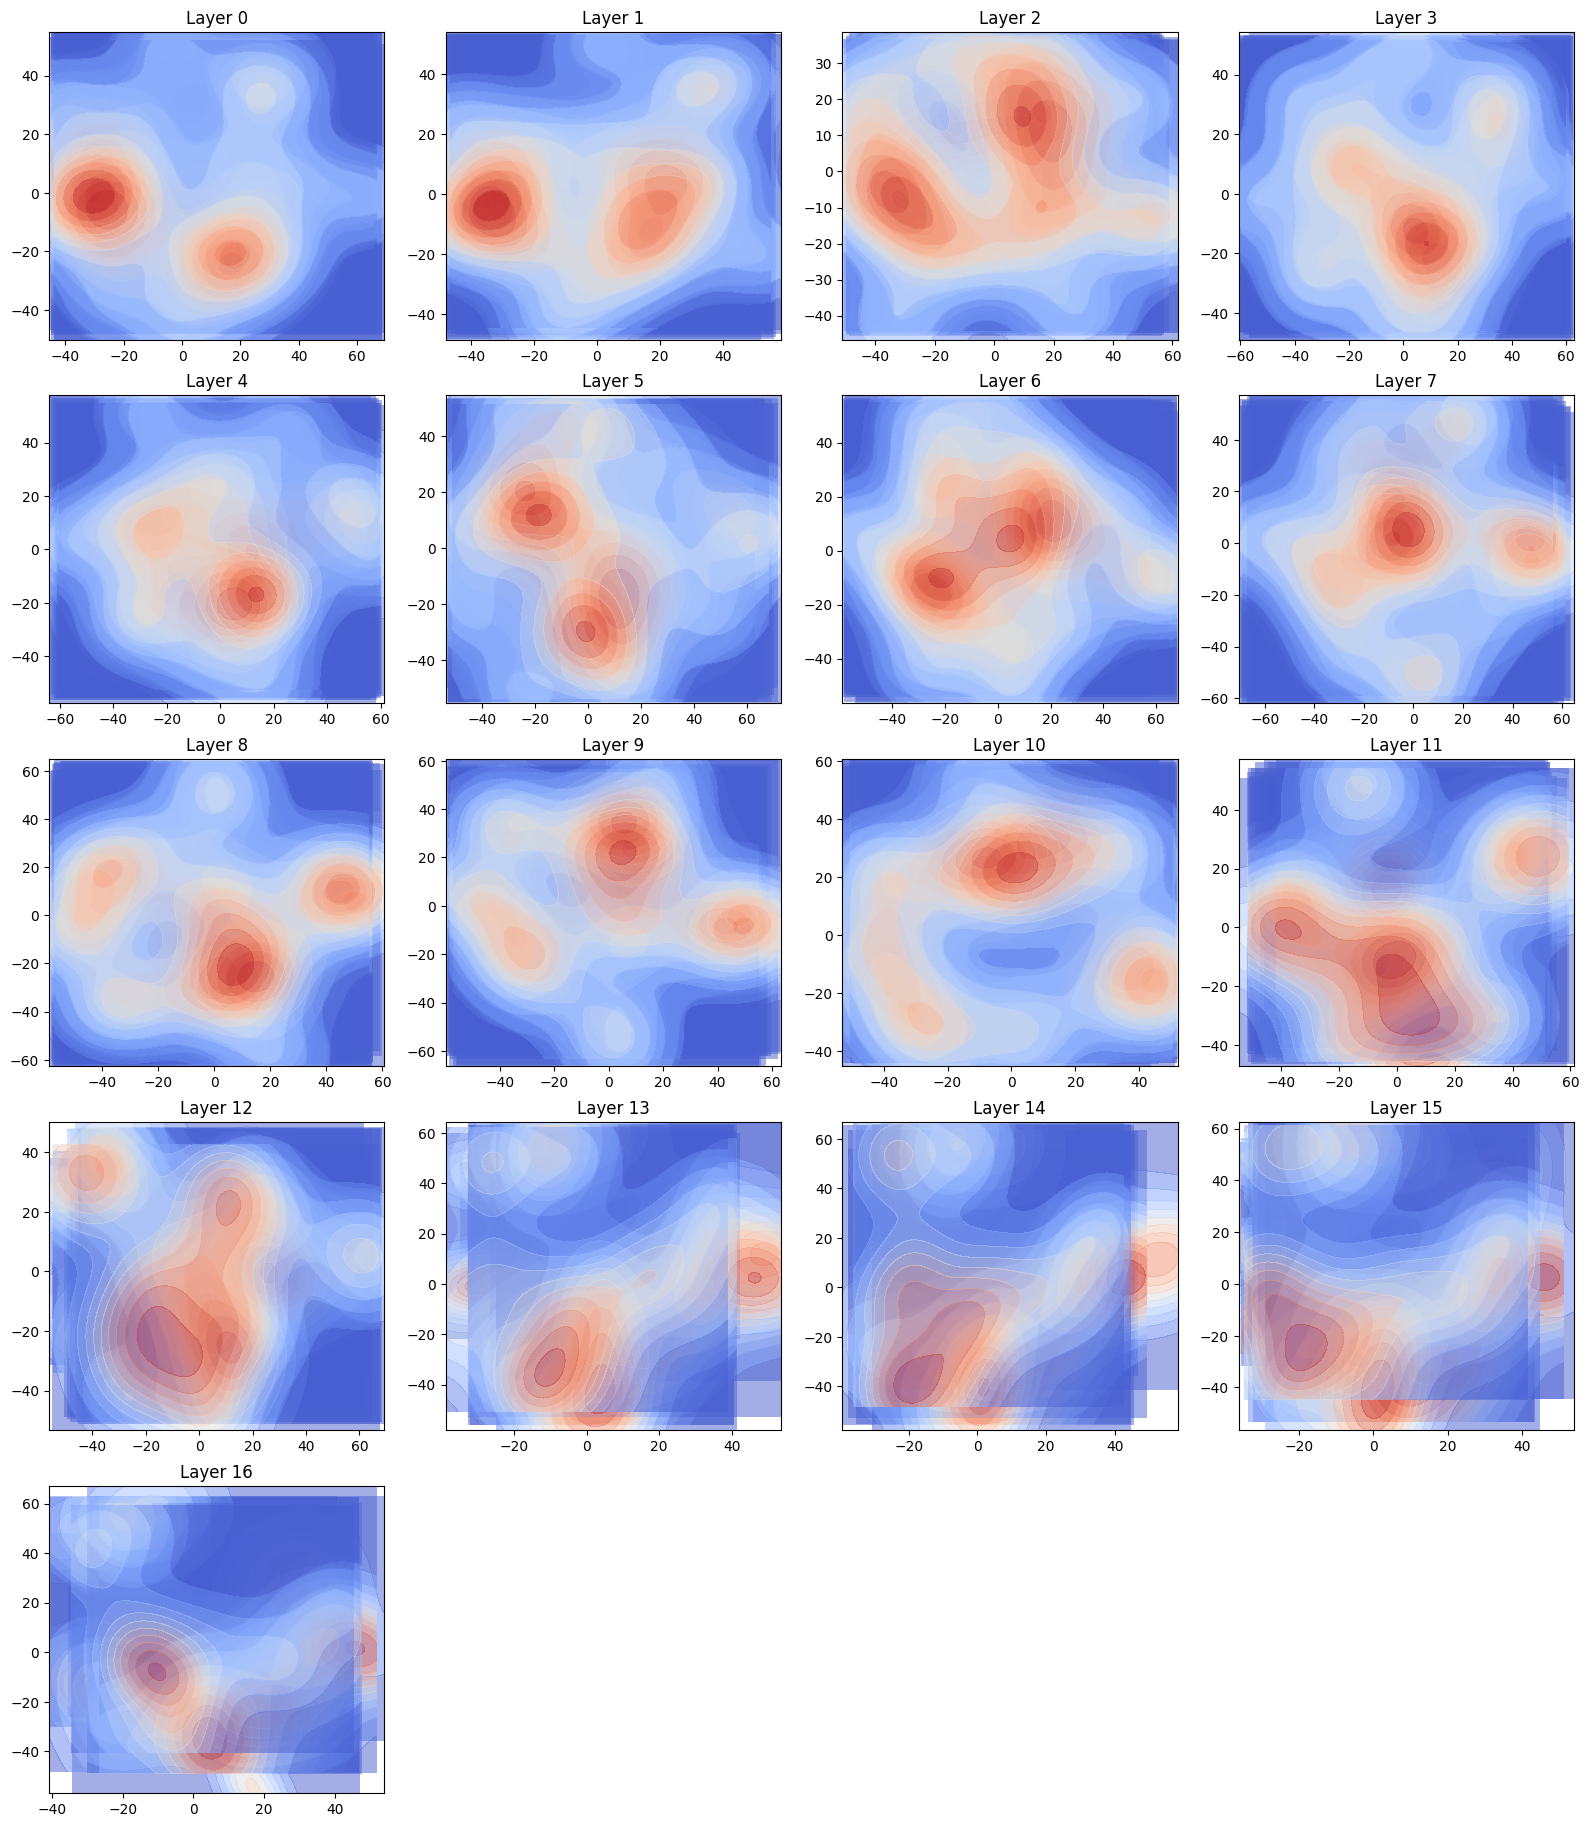

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

# Define parameters
num_layers = 17  # Number of layers to visualize
cols = 4  # Max number of columns per row
rows = (num_layers + cols - 1) // cols  # Calculate required rows dynamically

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  # Flatten for easy indexing

# Loop through layers and plot contour plots
for layer in range(num_layers):
    X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
    df["Category"] = dataset["category"]

    ax = axes[layer]  # Select subplot

    # Iterate through categories and plot contour per category
    for category in df["Category"].unique():
        subset = df[df["Category"] == category]
        if len(subset) < 2:  # Avoid issues with very small sample sizes
            continue

        # KDE for density estimation
        kde = gaussian_kde(subset[["TSNE-1", "TSNE-2"]].T)
        x_min, x_max = subset["TSNE-1"].min(), subset["TSNE-1"].max()
        y_min, y_max = subset["TSNE-2"].min(), subset["TSNE-2"].max()
        x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        z = kde(np.vstack([x.ravel(), y.ravel()])).reshape(x.shape)

        # Contour plot
        ax.contourf(x, y, z, levels=10, alpha=0.5, cmap="coolwarm")

    ax.set_title(f"Layer {layer}")

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

### umap on template dataset

/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circui

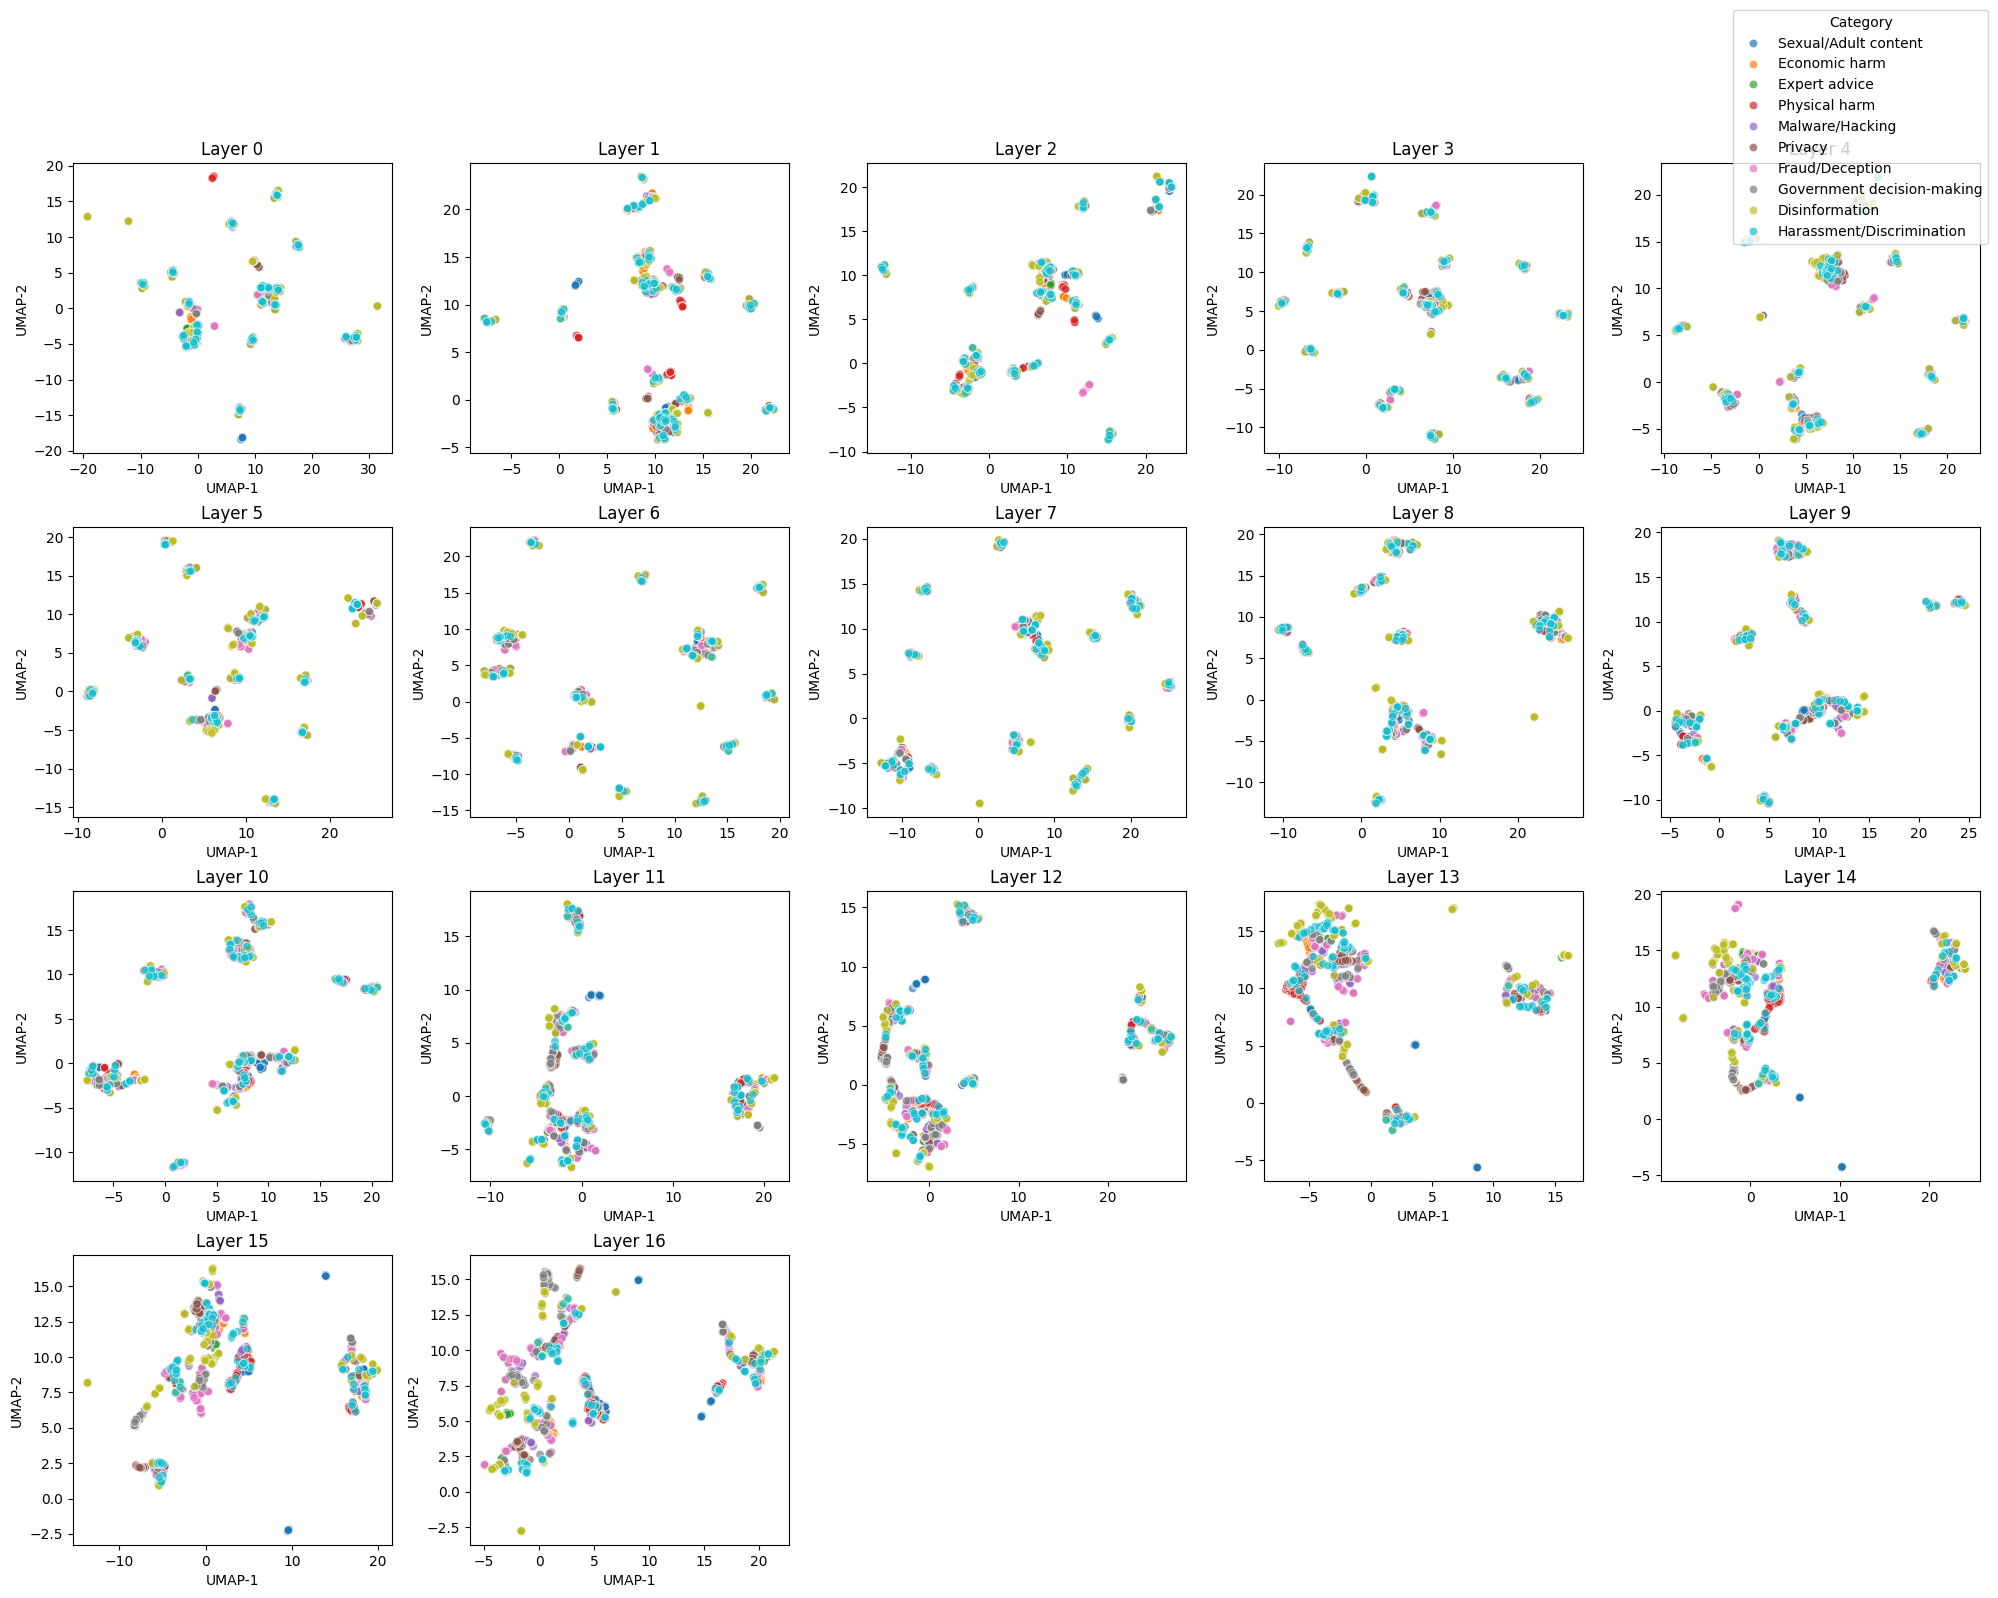

In [31]:
import umap
num_layers = 17  # Adjust based on your model
cols = 5  # Maximum number of columns in the grid
rows = (num_layers + cols - 1) // cols  # Dynamically calculate rows

# Create figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  # Flatten axes for easy indexing

# Loop through layers and plot UMAP embeddings
for layer in range(num_layers):
    X_embedded = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["UMAP-1", "UMAP-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="UMAP-1", y="UMAP-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()

### tsne on jailbreakbench

In [32]:
dataset=load_dataset("walledai/JailbreakBench",split="train")
template='''<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
'''

In [33]:
cache=defaultdict(list)
with tqdm(total=len(dataset), desc="Caching latents") as pbar:
    for i,item in enumerate(iter(dataset)):
        with torch.no_grad():
            inputs=tokenizer(template.format(prompt=item["prompt"]),return_tensors="pt",padding="max_length",max_length=512,truncation=True).to(device)
            outputs=model(**inputs)
            for i,item in enumerate(outputs.hidden_states[1:]):
                cache[f".model.layers.{i}"].append(item[0,-1,:].tolist())
        # Update the progress bar
        pbar.update(1)

Caching latents: 100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


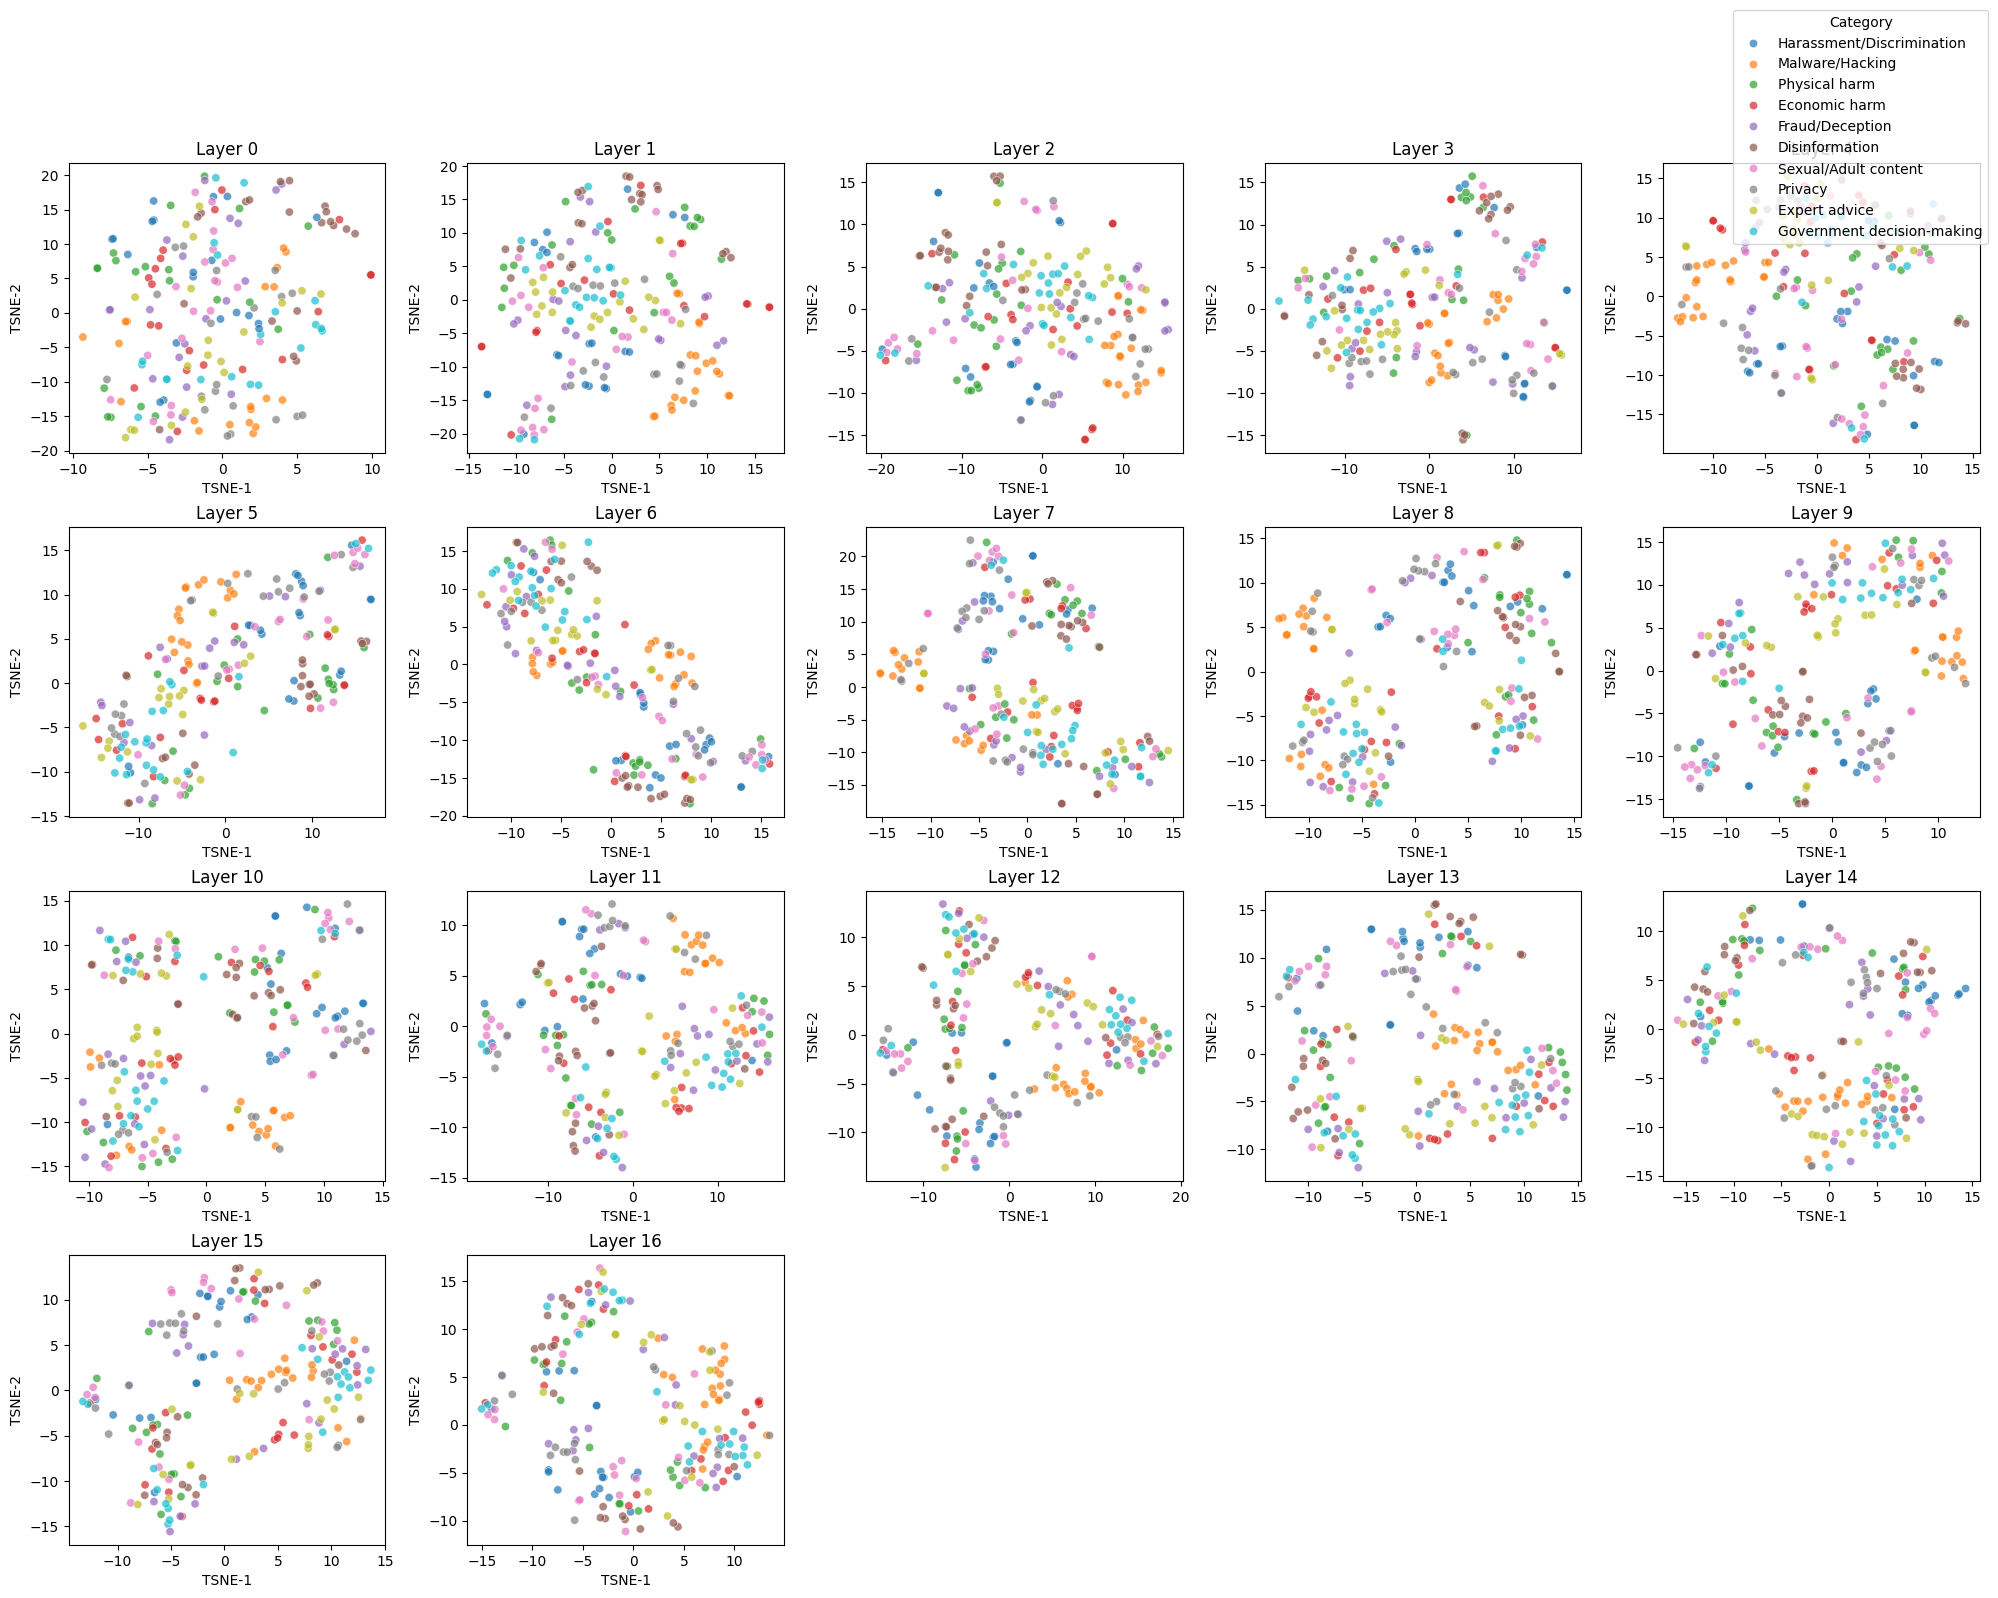

In [21]:
num_layers = 17  # Number of layers to visualize
cols = 5  # Max number of columns per row
rows = (num_layers + cols - 1) // cols  # Calculate required rows dynamically

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust size as needed
axes = axes.flatten()  # Flatten in case of multiple rows

# Loop through layers and plot in subplots
for layer in range(num_layers):
    X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="TSNE-1", y="TSNE-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove extra empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()

### umap on jailbreakbench

/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nirmal/miniconda3/envs/circui

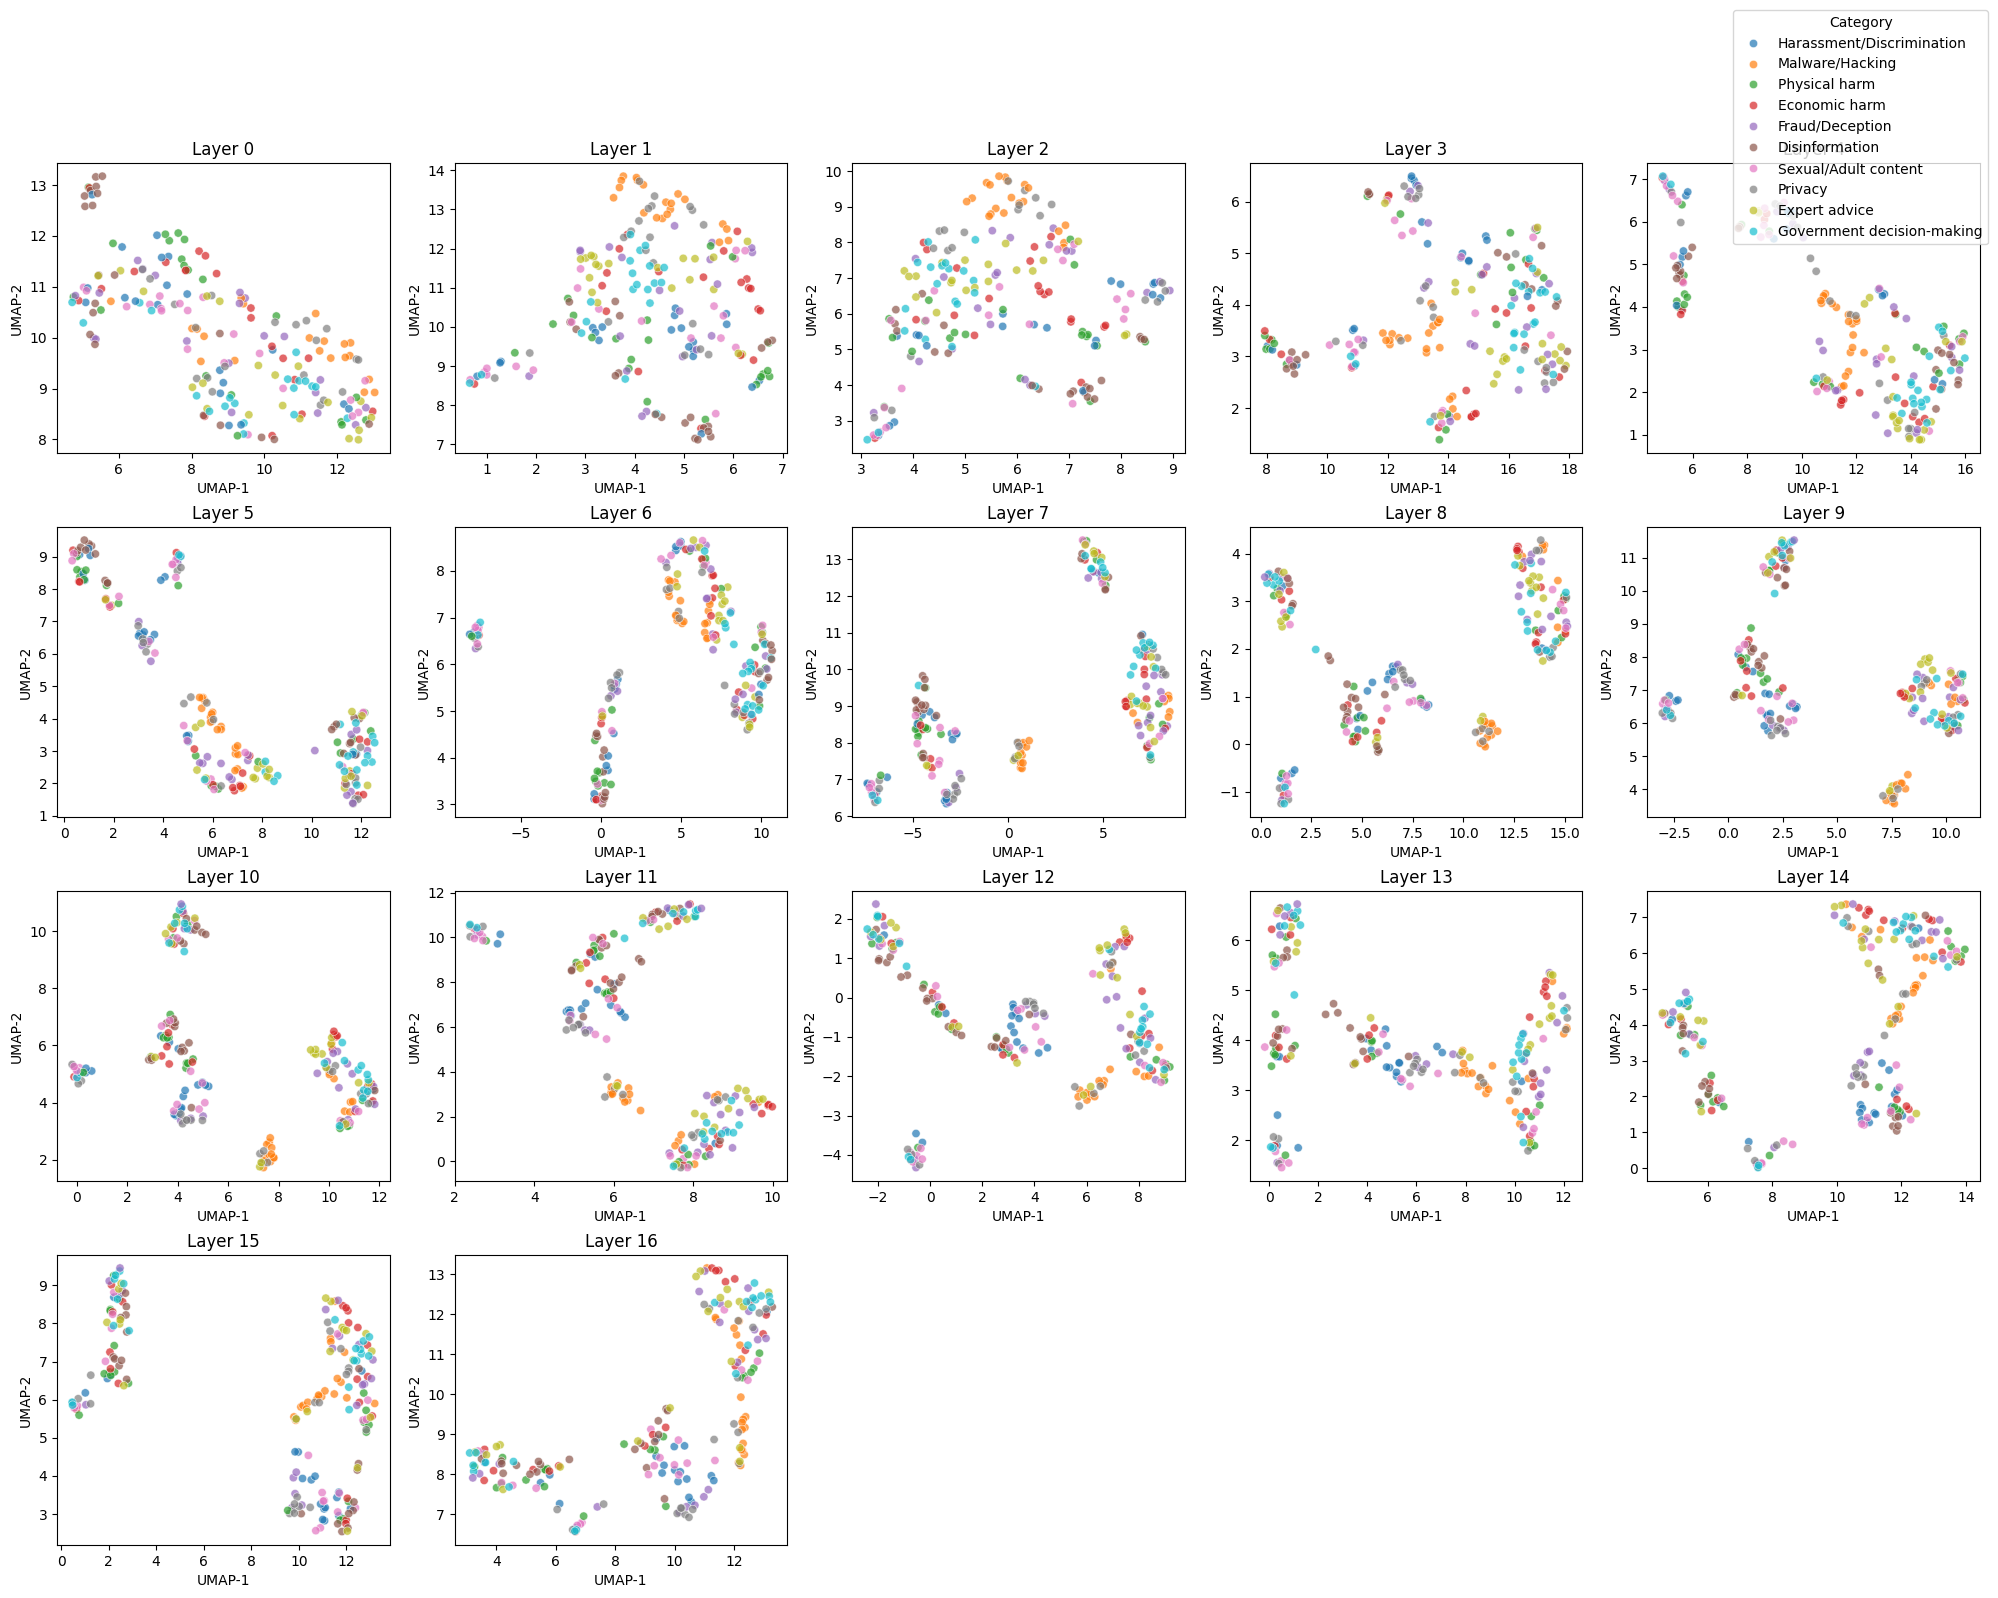

In [34]:
import umap
num_layers = 17  # Adjust based on your model
cols = 5  # Maximum number of columns in the grid
rows = (num_layers + cols - 1) // cols  # Dynamically calculate rows

# Create figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  # Flatten axes for easy indexing

# Loop through layers and plot UMAP embeddings
for layer in range(num_layers):
    X_embedded = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["UMAP-1", "UMAP-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="UMAP-1", y="UMAP-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()

### plot last position activation alignment along steering direction

In [11]:
# template dataset
# dataset=load_dataset("nirmalendu01/template_jailbreak",split="train")
# jailbreak dataset
dataset=load_dataset("walledai/JailbreakBench",split="train")

template='''<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
'''

# direction
direction = torch.load("./load_gemma/direction.pt").half().to(device)
direction = direction / torch.norm(direction)

/tmp/ipykernel_2994570/1693153553.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  direction = torch.load("./load_gemma/direction.pt").half().to(device)


In [ ]:
cache=defaultdict(list)
with tqdm(total=len(dataset), desc="Caching latents") as pbar:
    for i,item in enumerate(iter(dataset)):
        with torch.no_grad():
            inputs=tokenizer(template.format(prompt=item["prompt"]),return_tensors="pt",padding="max_length",max_length=512,truncation=True).to(device)
            outputs=model(**inputs)
            for i,item in enumerate(outputs.hidden_states[1:]):
                cache[f".model.layers.{i}"].append(item[0,-1,:].tolist())
        # Update the progress bar
        pbar.update(1)
        
# layer-wise mean
layer_mean = {k:torch.tensor(v).mean(dim=0).to(device) for k,v in cache.items()}
# normalize
layer_mean = {k:v / torch.norm(v) for k,v in layer_mean.items()} 

Caching latents:   0%|          | 0/1218 [00:00<?, ?it/s]The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
Caching latents: 100%|██████████| 1218/1218 [03:32<00:00,  5.73it/s]


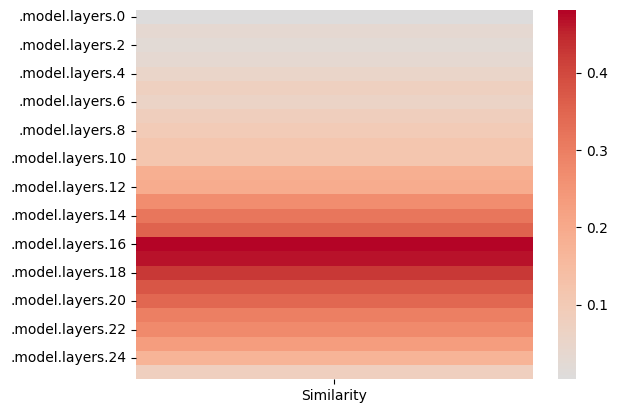

In [10]:
# cosine similarity with direction
layer_similarity = {k:torch.dot(v.half(),direction).item() for k,v in layer_mean.items()}

# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame.from_dict(layer_similarity,orient="index",columns=["Similarity"])
sns.heatmap(df,cmap="coolwarm",center=0)
plt.show()